# **Import Libaries**

In [1]:
import os
import sys 
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from PCA import PCA

# **Prepare Data**

## Load 200 images of UTKFace Dataset

In [2]:
#dataset of UTKFace
IMG_DIR = 'dataset_for_analysis'
images = []
images_flatten = []

total = sum(1 for entry in os.scandir(IMG_DIR) if entry.is_file())
count = 1
max_images = min(total, 200)
for img_path in os.listdir(IMG_DIR):
    if count == max_images + 1:
        break
    img_array = cv.imread(os.path.join(IMG_DIR,img_path), cv.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img_array)
    img_64 = np.array(img_pil.resize((64, 64), Image.ANTIALIAS))
    images.append(img_64)
    img_array = img_64.flatten()
    images_flatten.append(img_array)
    count += 1

C:\Users\Admin\AppData\Local\Temp\ipykernel_7992\1689735133.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_64 = np.array(img_pil.resize((64, 64), Image.ANTIALIAS))


## Flatten data

In [3]:
images_flatten = np.asarray(images_flatten)

## Split Data

In [4]:
X_train, X_test = train_test_split(images_flatten, test_size = 0.5, random_state = 42)
X_train = X_train.T
X_test = X_test.T

## Visualize

C:\Users\Admin\AppData\Local\Temp\ipykernel_23188\1935647495.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i)


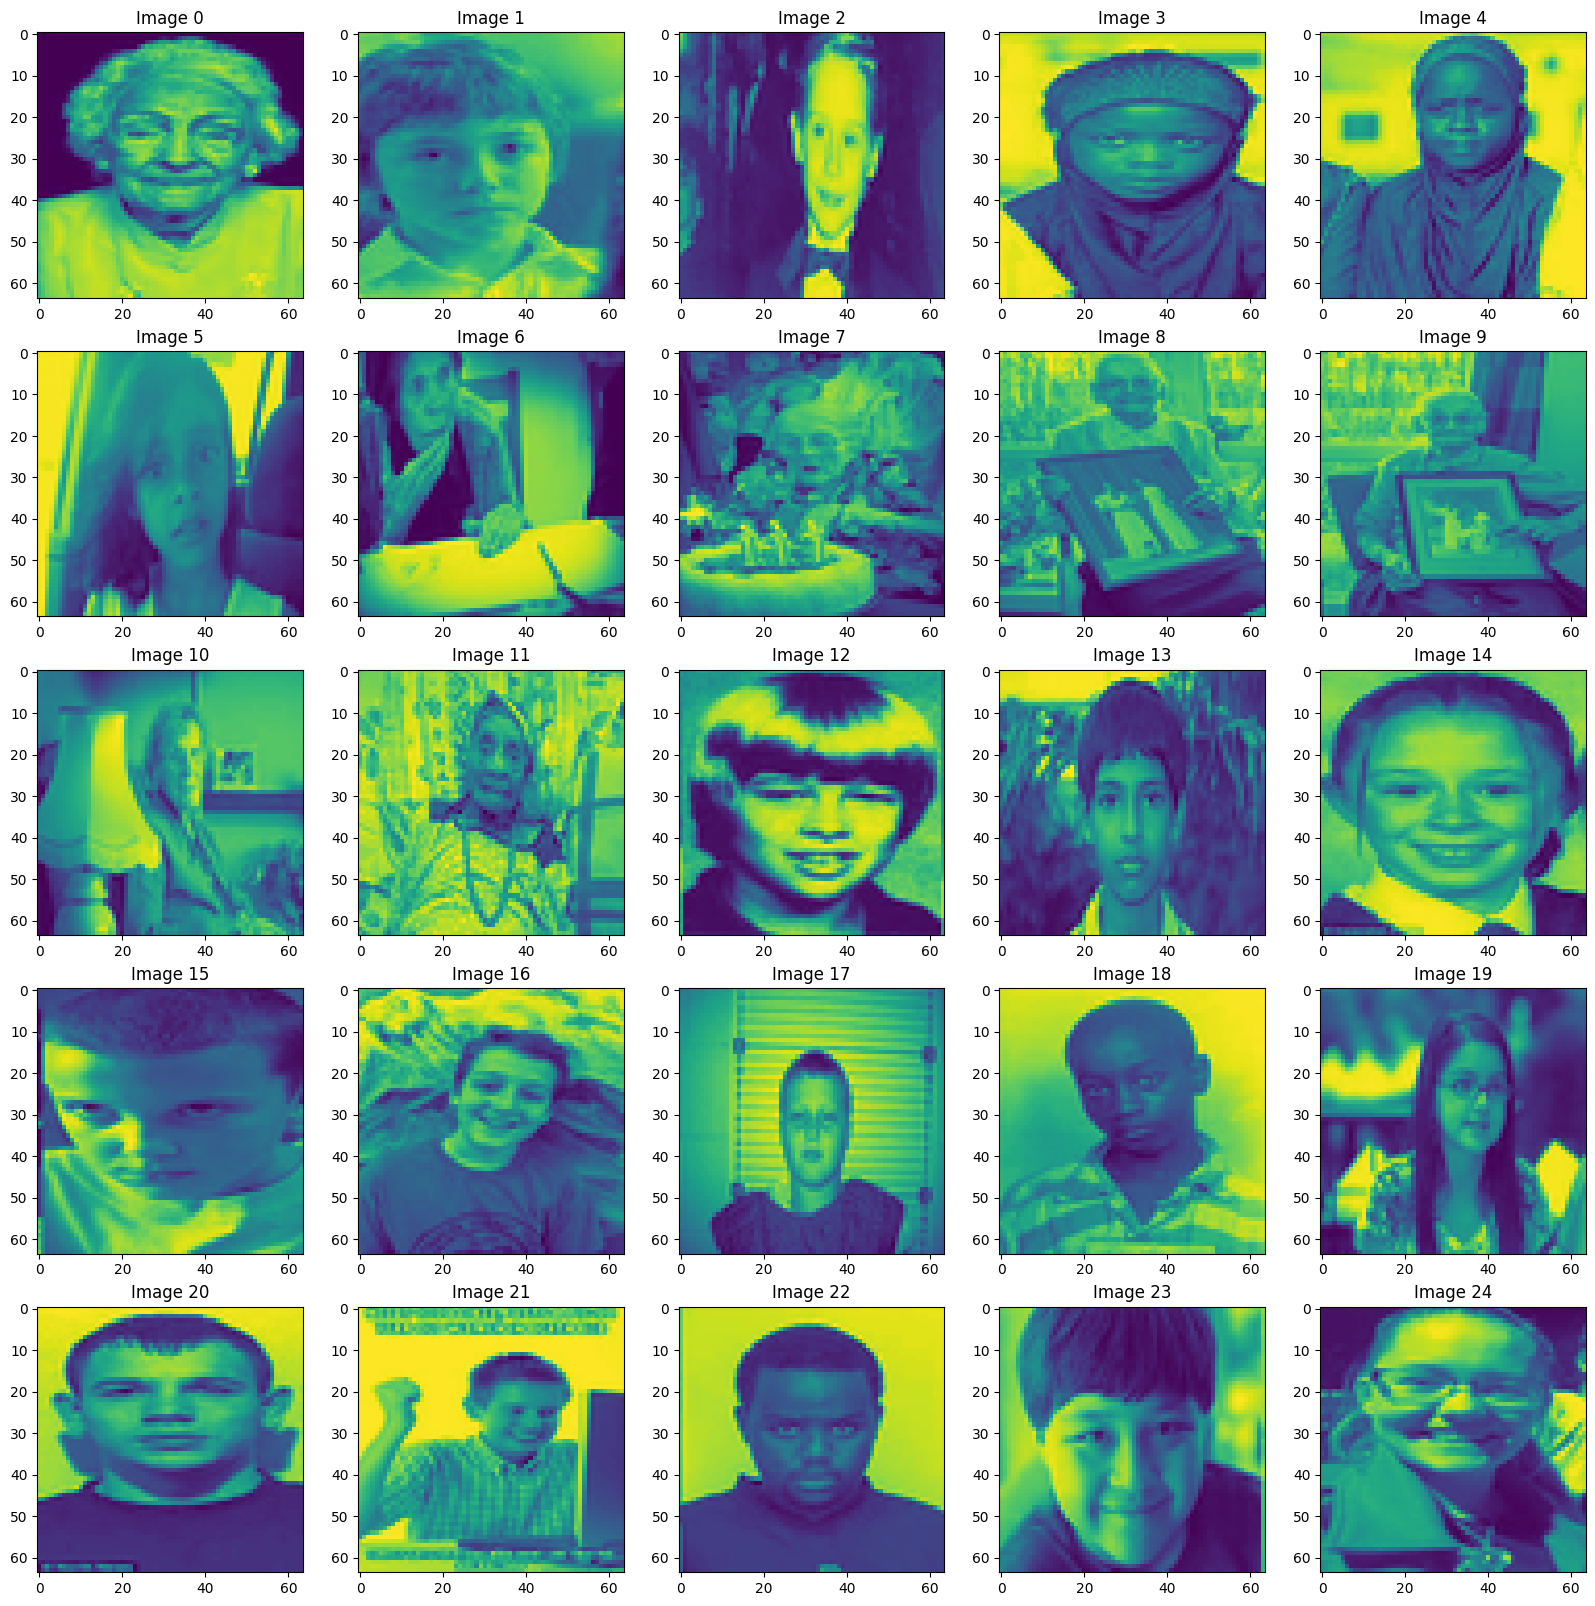

In [5]:
fig, ax = plt.subplots(figsize = (20, 20))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.title('Image {}'.format(i-1))
    plt.imshow(images[i-1])

## Distance Metric

In [5]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis = 1).mean()

# **Training and Testing ( 100 components )**
## *I use the test set to try to check whether "unseen data" can match the previous space or not?*

In [6]:
model = PCA()

In [7]:
Xbar_train, mu_train, std_train = model.standardize(X_train)

In [8]:
max_components = 99
if max_components <= Xbar_train.shape[1]:
    model.optimize = True
model.fit(Xbar_train)

In [9]:
Xbar_test, mu_test, std_test = model.standardize(X_test)

In [13]:
PCs = model.preserved_var_explained(0.4)
PCs

4

In [26]:
loss = []
reconstructions = []
print("Processing...")
animation = np.arange(1, max_components, 1)

for num_component in range(1, max_components + 1,1):
    sys.stdout.write("\r" + str(animation[num_component - 1]) + " / " + str(max_components))
    sys.stdout.flush()
    reconstructed_img = model.reconstruct_img(Xbar_test, mu_test, num_component)
    error = mse(reconstructed_img, Xbar_test)
    reconstructions.append(reconstructed_img)
    loss.append((num_component, error))
print()
print("Done!")

Processing...
98 / 99

IndexError: index 98 is out of bounds for axis 0 with size 98

In [27]:
reconstructions = np.asarray(reconstructions)
loss = np.asarray(loss)

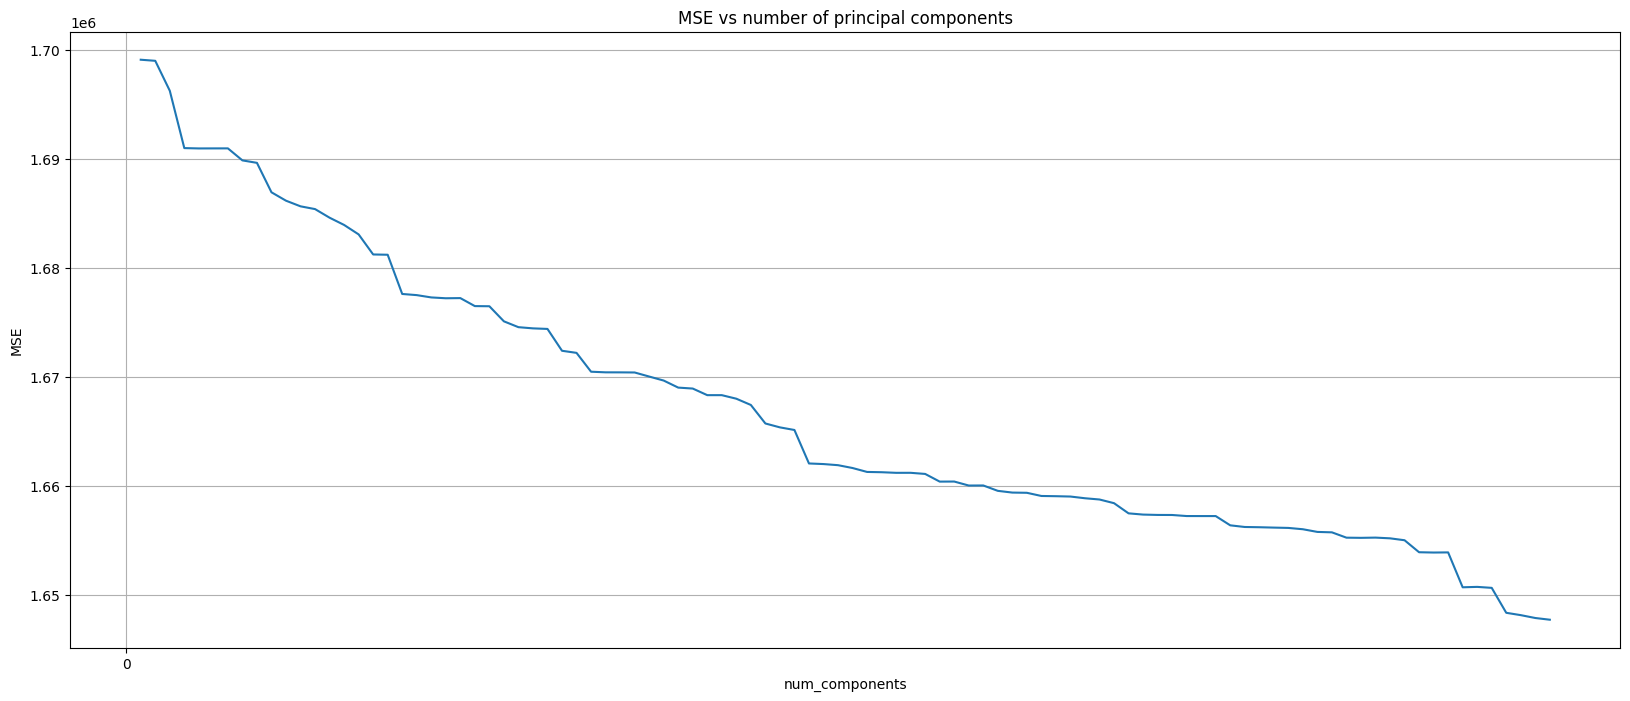

In [28]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(loss[:,0], loss[:,1])
ax.xaxis.set_ticks(np.arange(0, max_components, 400))
ax.set(xlabel = 'num_components', ylabel = 'MSE', title = 'MSE vs number of principal components')
plt.grid()

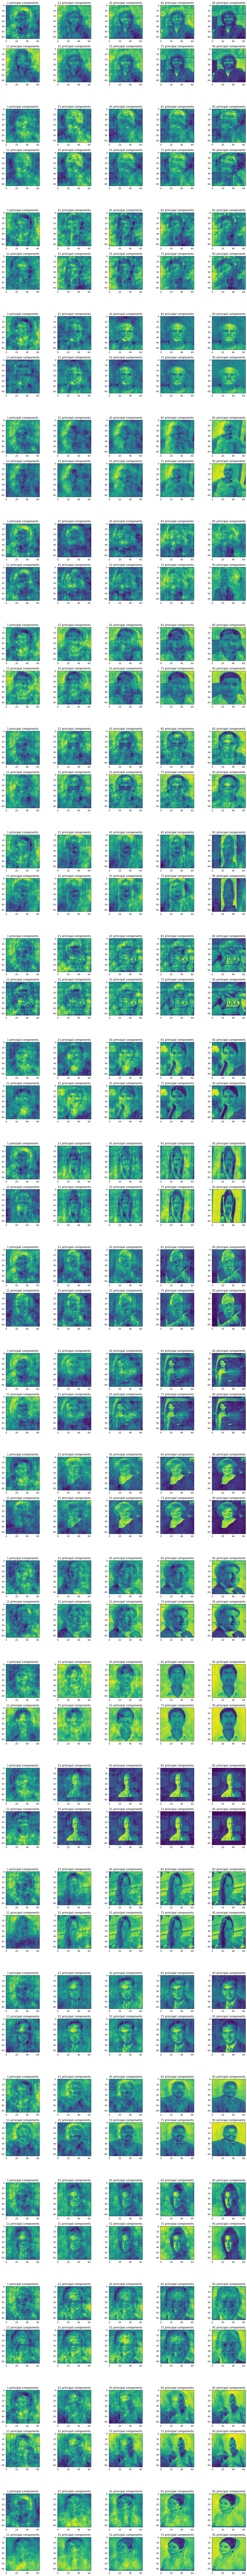

In [29]:
n = 25 # number of double-rows
m = 5 # number of columns
t = 0.9 # 1-t == top space 
b = 0.1 # bottom space      (both in figure coordinates)
msp = 0.3 # minor spacing
sp = 0.8  # major spacing
offs = (1+msp) * (t-b) / (2*n + n*msp + (n-1)*sp) # grid offset
hspace = sp + msp + 1 #height space per grid
gso = GridSpec(n, m, bottom = b+offs, top = t, hspace = hspace)
gse = GridSpec(n, m, bottom = b, top = t-offs, hspace = hspace)
fig = plt.figure(figsize=(20, 200))
axes = []
for i in range(n*m):
    axes.append(fig.add_subplot(gso[i]))
    axes.append(fig.add_subplot(gse[i]))
for i in range(25):
    k = 1
    for j in range(10):
        axes[j + i*10].set_title('{} principal components'.format(k))
        axes[j + i*10].imshow(reconstructions[k, :, i].reshape(64, 64))
        k += 10
plt.show()